Quantizing Model

In [1]:
import keras
import tensorflow as tf
import numpy as np
import random
import cv2
import pathlib
from typing import Any, Mapping
from absl import logging
from official.projects.movinet.modeling import movinet
from official.projects.movinet.modeling import movinet_model
from official.projects.movinet.tools import export_saved_model
import functools
import imageio
import os
from tensorflow_docs.vis import embed

2023-10-20 15:18:11.810711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 15:18:12.927676: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
def format_frames(frame):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  f32frame = tf.image.convert_image_dtype(frame, tf.float32)
  try:
    logging.warning('resize frame : ' + str(tf.shape(f32frame)))
    frame = tf.image.resize_with_pad(image=f32frame, target_height=172, target_width=172)
  except ValueError or tf.errors.InvalidArgumentError:
    frame = np.zeros((172,172,3), tf.float32)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (172,172), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret = False
  while ret == False:
    ret, frame = src.read()
  
  result.append(format_frames(frame))
  logging.warning('video frame shape: ' + str(tf.shape(format_frames(frame))))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]
  # result = np.array(result)
  return result

class FrameGenerator:
  def __init__(self, path: pathlib.PosixPath, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label


# batch_size = 1
num_frames = 8
num_class = 101
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
val_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.PosixPath('UCF101_subset/val/'), num_frames),
                                          output_signature = output_signature)
# val_ds = val_ds.batch(batch_size)


In [3]:
model_id = 'a0'
use_positional_encoding = model_id in {'a3', 'a4', 'a5'}
resolution = 172

# Create backbone and model.
backbone = movinet.Movinet(
    model_id=model_id,
    causal=True,
    conv_type='2plus1d',
    se_type='2plus3d',
    activation='hard_swish',
    gating_activation='hard_sigmoid',
    use_positional_encoding=use_positional_encoding,
    use_external_states=True,
)

model = movinet_model.MovinetClassifier(
    backbone,
    num_classes=101,
    output_states=True)

# Create your example input here.
# Refer to the paper for recommended input shapes.
inputs = tf.ones([1, 13, 172, 172, 3])

# [Optional] Build the model and load a pretrained checkpoint.
model.build(inputs.shape)

# Load weights from the checkpoint to the rebuilt model
checkpoint_dir = 'trained_model'
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [4]:
saved_model_dir = 'model'
input_shape = [1, 1, 172, 172, 3]
# Convert to saved model
export_saved_model.export_saved_model(
    model=model,
    input_shape=input_shape,
    export_path=saved_model_dir,
    causal=True,
    bundle_input_init_states_fn=False)
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_filename = 'tflite_models/model.tflite'


2023-10-20 15:19:15.580469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


/tmp/ipykernel_20724/3446328486.py:50: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  logging.warn('video frame shape: ' + str(tf.shape(frame)))



FieldHockeyPenalty 0.99968636
FrisbeeCatch 0.00028919431
BaseballPitch 2.443928e-05
Basketball 1.2682226e-08
CricketBowling 1.0596558e-08



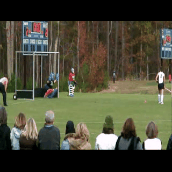

In [ ]:
CLASSES = sorted(os.listdir('./UCF101_subset/train1'))
def get_top_k(probs, k=5, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=200, loop=0)
  return embed.embed_file('./animation.gif')


# Create initial states for the stream model
init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=[1, 1, 172, 172, 3])))

all_logits = []

# To run on a video, pass in one frame at a time
states = init_states
for frames, label in val_ds.take(1):
  for clip in frames:
    # Input shape: [1, 1, 172, 172, 3]
    clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
    logits, states = model.predict({**states, 'image': clip}, verbose=0)
    all_logits.append(logits)

logits = tf.concat(all_logits, 0)
probs = tf.nn.softmax(logits)

final_probs = probs[-1]
top_k = get_top_k(final_probs)
print()
for label, prob in top_k:
  print(label, prob)

frames, label = list(val_ds.take(1))[0]
to_gif(frames.numpy())

In [ ]:
data = iter(val_ds)
frames, label = next(data)
print(tf.shape(frames))
frames = tf.split(frames, frames.shape[1], axis=1)

print(tf.shape(frames))
print(label)


tf.Tensor([  8 172 172   3], shape=(4,), dtype=int32)
tf.Tensor([172   8   1 172   3], shape=(5,), dtype=int32)
tf.Tensor(28, shape=(), dtype=int16)


In [17]:
def representative_dataset_generator(
    model: tf.keras.Model,
    dataset_iter: Any,
    init_states: Mapping[str, tf.Tensor],
    num_samples_per_video = 3,
    num_calibration_videos = 100
):
  counter = 0
  for i in range(num_calibration_videos):
    if i % 100 == 0:
      logging.info('Reading representative dataset id %d.', i)
    loaded = False
    while loaded == False:
      try:
        example_input, example_label = next(dataset_iter)
        loaded = True
      except KeyboardInterrupt:
        break
      except:
        logging.warning('reload video')
        
    
    # groundtruth_label_id = tf.argmax(example_label, axis=-1)
    input_states = init_states
    # split video into frames along the temporal dimension.
    frames = example_input
    # frames = tf.split(example_input, example_input.shape[1], axis=1)

    # random_indices = np.random.randint(
    #     low=1, high=len(frames), size=num_samples_per_video)
    # # always include the first frame
    # random_indices[0] = 0
    # random_indices = set(random_indices)

    for frame_index, frame in enumerate(frames):
      logging.warning('frame shape: '+ str(tf.shape(frame)))
      try:
        frame = tf.expand_dims(tf.expand_dims(frame, axis=0), axis=0)
        predictions, output_states = model({'image': frame, **input_states})
        # if frame_index in random_indices:
        yield {'image': frame, **input_states}
        counter += 1
        # update states for the next inference step
        input_states = output_states
      
      except GeneratorExit:
        return
      except:
        pass

      

init_states_fn = model.init_states
init_states = init_states_fn(tf.shape(tf.ones(shape=input_shape)))
# print(init_states['image'])
rep_dataset = functools.partial(representative_dataset_generator, model=model, dataset_iter=iter(val_ds), init_states=init_states)
a = rep_dataset()


In [21]:
for i in range(5):
    logging.warning(i)
    next(a)
print(tf.shape(np.zeros((172,172,3))))

2023-10-20 15:32:06.397758: W tensorflow/core/framework/op_kernel.cc:1816] UNKNOWN: InvalidArgumentError: 2 root error(s) found.
  (0) INVALID_ARGUMENT: {{function_node __wrapped__GreaterEqual_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 14792 values, but the requested shape has 0
	 [[{{node y/_3}}]]
  (1) INVALID_ARGUMENT: {{function_node __wrapped__GreaterEqual_device_/job:localhost/replica:0/task:0/device:GPU:0}} Input to reshape is a tensor with 14792 values, but the requested shape has 0
	 [[{{node x/_2}}]]
0 successful operations.
0 derived errors ignored. [Op:GreaterEqual] name: 
Traceback (most recent call last):

  File "/home/wldnjs/on-device-action-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 268, in __call__
    ret = func(*args)

  File "/home/wldnjs/on-device-action-recognition/.venv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return 

tf.Tensor([172 172   3], shape=(3,), dtype=int32)


In [ ]:



# loaded = tf.saved_model.load(saved_model_dir)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops =[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# del init_states['image']
converter.representative_dataset = functools.partial(representative_dataset_generator, 
                                                     model=model, dataset_iter=val_ds.as_numpy_iterator(), init_states=init_states)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
tflite_model_int8 = converter.convert()

with open(tflite_filename+".int8", 'wb') as f:
  f.write(tflite_model_int8)

# Create the interpreter and signature runner
interpreter = tf.lite.Interpreter(model_path=tflite_filename+".int8")
runner = interpreter.get_signature_runner()

2023-10-20 00:28:56.389332: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-10-20 00:28:56.389380: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-10-20 00:28:56.389900: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: model
2023-10-20 00:28:56.531861: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-10-20 00:28:56.531895: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: model
2023-10-20 00:28:56.793646: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-10-20 00:28:56.844867: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-10-20 00:28:57.577973: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: model
2023-10-20 00:28:58.006874: I tensorflow

In [8]:
a = np.zeros((172,172,3))
print(tf.shape(a))
print(tf.shape(np.zeros_like(a)))

tf.Tensor([172 172   3], shape=(3,), dtype=int32)
tf.Tensor([172 172   3], shape=(3,), dtype=int32)
